band - (train, test)
vv - (1.00, 0.99)
vh - ()
vhvv - ()

In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append('../')

from data.data_utils import *
from data.dataset import *

sns.set_theme()
cmap = sns.color_palette("tab10", as_cmap=True)

### Loading MOMENT outputs

In [2]:
# Load keys
data_path = '/u/ayang1/foundm/scratch_sc/data/s1_lucas/datasets'
with xr.open_dataset(os.path.join(data_path, 'portugal.h5')) as ds:
    labels = np.unique(ds.label)
    keys = encode_labels(labels)
keys

{'B11': 0,
 'B12': 1,
 'B13': 2,
 'B14': 3,
 'B15': 4,
 'B16': 5,
 'B18': 6,
 'B21': 7,
 'B23': 8,
 'B41': 9,
 'B42': 10,
 'B52': 11,
 'B53': 12,
 'B54': 13,
 'B55': 14,
 'B71': 15}

In [3]:
output_path = '/u/ayang1/foundm/models/moment/moment_outputs'
with open(os.path.join(output_path, 'outputs.pkl'), 'rb') as f:
    model_outputs = pkl.load(f)
    
# Embeddings averaged across bands and patches
model_embeddings = model_outputs['embeddings'].mean(axis=1, keepdims=False)
model_labels = np.array([np.argmax(x) for x in model_outputs['labels']])

print(model_embeddings.shape, model_labels.shape)

(3659, 3072) (3659,)


In [4]:
labels, counts = np.unique(model_labels, return_counts=True)
to_drop = []
for i in range(len(labels)):
    if counts[i] <= 25:
        to_drop.append(labels[i])
to_drop

[8, 9, 15]

In [5]:
row_mask = [False if x in to_drop else True for x in model_labels]
embeddings = model_embeddings[row_mask, :]
labels = model_labels[row_mask] 

In [6]:
from momentfm.models.statistical_classifiers import fit_svm
from sklearn.model_selection import train_test_split

train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings, labels, test_size=0.33, random_state=42)
clf = fit_svm(features=train_embeddings, y=train_labels)

y_pred_train = clf.predict(train_embeddings)
y_pred_test = clf.predict(test_embeddings)
train_accuracy = clf.score(train_embeddings, train_labels)
test_accuracy = clf.score(test_embeddings, test_labels)

print(f"Train accuracy: {train_accuracy:.2f}")
print(f"Test accuracy: {test_accuracy:.2f}")


/u/ayang1/.conda/envs/moment/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/u/ayang1/.conda/envs/moment/lib/python3.11/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Train accuracy: 1.00
Test accuracy: 0.97


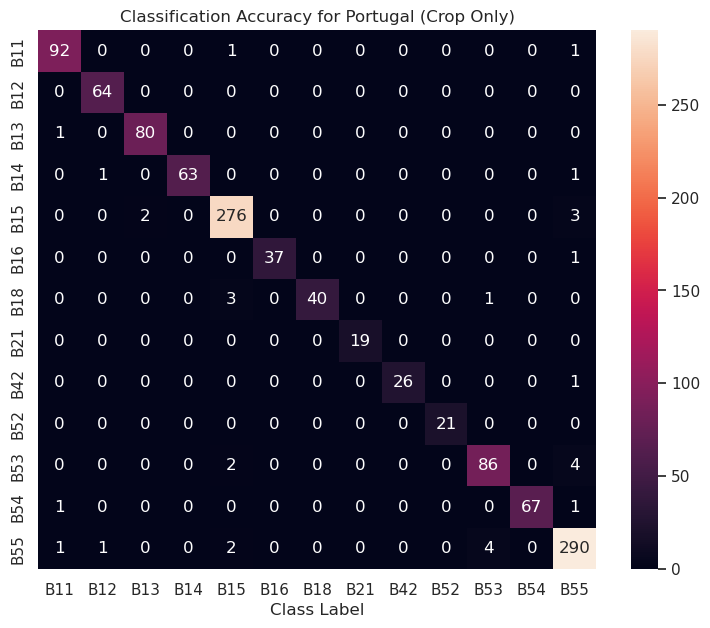

In [79]:
from sklearn.metrics import confusion_matrix
reverse = dict(zip(keys.values(), keys.keys()))

cf_matrix = confusion_matrix(
    test_labels, 
    y_pred_test
    )
fig = plt.figure(figsize=(9,7))
sns.heatmap(
    cf_matrix, 
    annot=True, fmt='d', 
    xticklabels=[reverse[x] for x in np.unique(y_pred_test)],
    yticklabels=[reverse[x] for x in np.unique(y_pred_test)])
plt.title('Classification Accuracy for Portugal (Crop Only)')
plt.xlabel('Class Label')
plt.show()

In [76]:
np.unique([reverse[x] for x in test_labels], return_counts=True)

(array(['B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B18', 'B21', 'B42',
        'B52', 'B53', 'B54', 'B55'], dtype='<U3'),
 array([ 94,  64,  81,  65, 281,  38,  44,  19,  27,  21,  92,  69, 298]))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, y_pred_test, target_names=keys.keys()))

              precision    recall  f1-score   support

         B11       0.95      0.97      0.96       113
         B12       0.91      0.94      0.92        63
         B13       1.00      0.99      0.99        98
         B14       0.98      0.98      0.98        84
         B15       0.97      0.98      0.98       349
         B16       0.97      0.90      0.94        40
         B18       1.00      0.92      0.96        63
         B21       1.00      1.00      1.00        26
         B23       1.00      1.00      1.00         3
         B41       1.00      1.00      1.00         5
         B42       1.00      1.00      1.00        30
         B52       1.00      1.00      1.00        26
         B53       0.97      0.94      0.96       104
         B54       1.00      0.98      0.99        86
         B55       0.96      0.97      0.97       372
         B71       1.00      1.00      1.00         2

    accuracy                           0.97      1464
   macro avg       0.98   

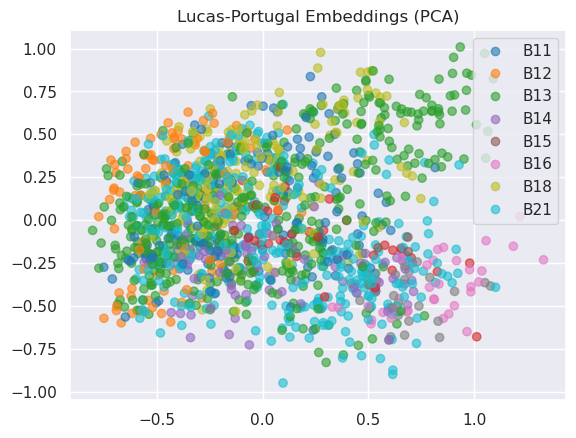

In [15]:
from sklearn.decomposition import PCA

test_embeddings_manifold = PCA(n_components=2).fit_transform(test_embeddings) 

plt.title(f"Lucas-Portugal Embeddings (PCA)")
fig = plt.scatter(
    test_embeddings_manifold[:, 0], 
    test_embeddings_manifold[:, 1],
    c=test_labels.squeeze(),
    cmap=cmap,
    alpha=0.6,
)
plt.legend(handles=fig.legend_elements()[0], labels=keys.keys())
plt.show()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f00f50614e0>
Traceback (most recent call last):
  File "/u/ayang1/.conda/envs/moment/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/u/ayang1/.conda/envs/moment/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/u/ayang1/.conda/envs/moment/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/u/ayang1/.conda/envs/moment/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'None

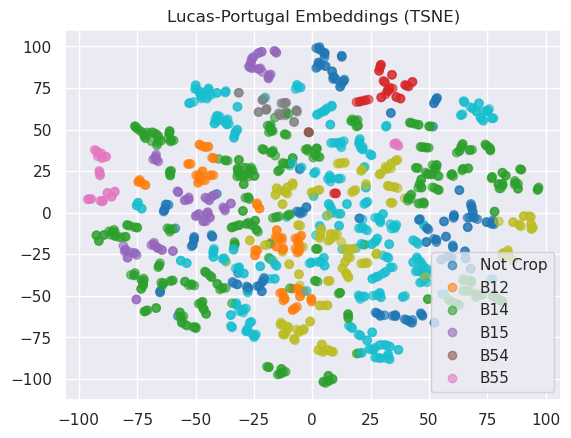

In [18]:
import numpy as np
from sklearn.manifold import TSNE

test_embeddings_manifold = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(test_embeddings)

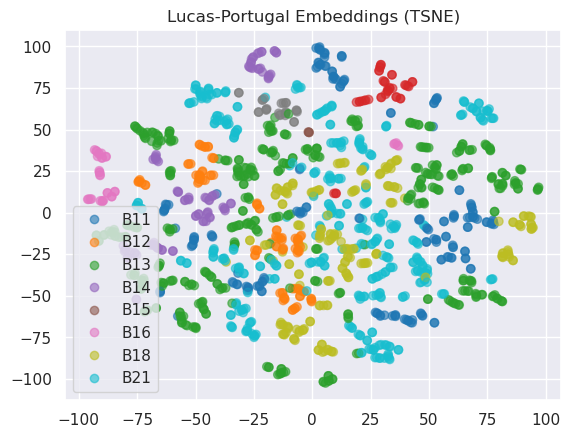

: 

In [19]:
plt.title(f"Lucas-Portugal Embeddings (TSNE)")
plt.scatter(
    test_embeddings_manifold[:, 0], 
    test_embeddings_manifold[:, 1],
    c=test_labels.squeeze(),
    cmap=cmap,
    alpha=0.6,
)

plt.legend(handles=fig.legend_elements()[0], labels=keys.keys())
plt.show()